In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data  # optional, for binary_blobs
from skimage.util import random_noise

# Set matplotlib to display images inline
%matplotlib inline

def plot_comparison(original, processed, title_orig, title_proc, cmap='gray'):
    """Side-by-side comparison of two images."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].imshow(original, cmap=cmap)
    axes[0].set_title(title_orig)
    axes[0].axis('off')
    axes[1].imshow(processed, cmap=cmap)
    axes[1].set_title(title_proc)
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

def morph_opening(image, kernel_size, shape=cv2.MORPH_RECT):
    """Perform morphological opening."""
    kernel = cv2.getStructuringElement(shape, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morph_closing(image, kernel_size, shape=cv2.MORPH_RECT):
    """Perform morphological closing."""
    kernel = cv2.getStructuringElement(shape, (kernel_size, kernel_size))
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

In [4]:
# ------------------------------------------------------------
# Test image 1: Noisy binary shapes (salt & pepper noise)
# ------------------------------------------------------------
np.random.seed(42)
clean = data.binary_blobs(length=256, blob_size_fraction=0.2, volume_fraction=0.4)
clean = (clean * 255).astype(np.uint8)

# Add salt & pepper noise (5% density)
noisy = random_noise(clean, mode='s&p', amount=0.05)
noisy = (noisy * 255).astype(np.uint8)

# ------------------------------------------------------------
# Test image 2: Binary shape with intentional gaps
# ------------------------------------------------------------
gaps = np.zeros((256, 256), dtype=np.uint8)
cv2.rectangle(gaps, (80, 80), (180, 180), 255, -1)   # solid square
cv2.rectangle(gaps, (120, 120), (140, 140), 0, -1)   # small hole inside
gaps[80:180, 100:102] = 0      # vertical gap
gaps[100:102, 80:180] = 0      # horizontal gap (cross)

## 3. Results – Opening for Noise Removal

We apply **opening** with a 3×3 rectangular structuring element to the noisy binary image.  
Opening removes isolated white noise pixels (salt) and smooths boundaries.

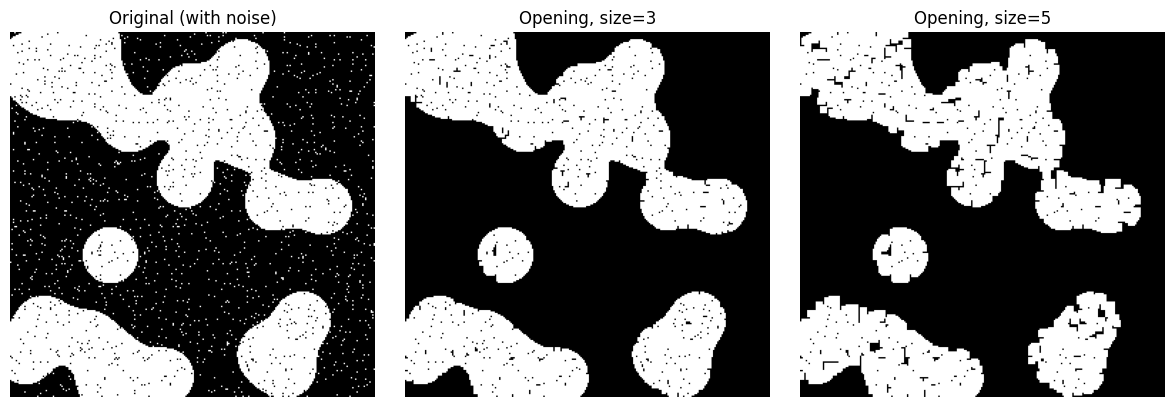

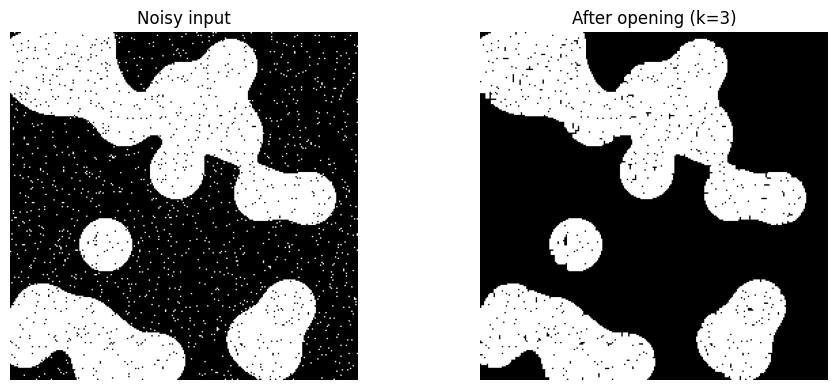

In [5]:
kernel_sizes = [3, 5]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(noisy, cmap='gray')
axes[0].set_title('Original (with noise)')
axes[0].axis('off')

for i, ksize in enumerate(kernel_sizes):
    opened = morph_opening(noisy, ksize)
    axes[i+1].imshow(opened, cmap='gray')
    axes[i+1].set_title(f'Opening, size={ksize}')
    axes[i+1].axis('off')
plt.tight_layout()
plt.show()

# Show close-up for better visibility
plot_comparison(noisy, morph_opening(noisy, 3),
                'Noisy input', 'After opening (k=3)')

## 4. Results – Closing for Gap Filling

Now we apply **closing** to the image with broken edges and interior holes.  
Closing with a sufficiently large kernel reconnects broken parts and fills cavities.

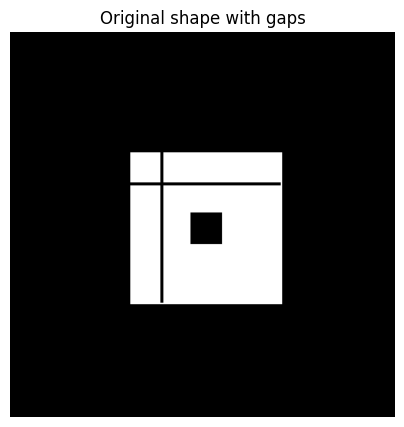

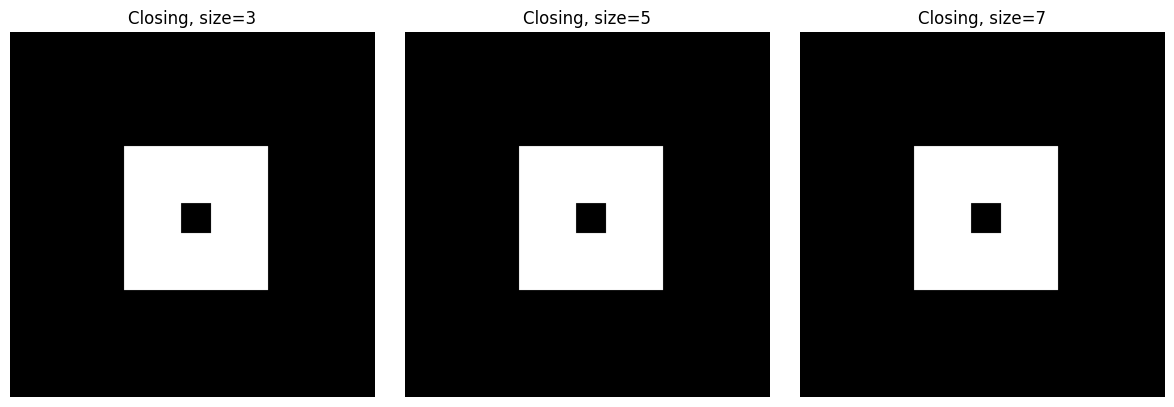

In [6]:
# Show original gaps
plt.figure(figsize=(5,5))
plt.imshow(gaps, cmap='gray')
plt.title('Original shape with gaps')
plt.axis('off')
plt.show()

# Apply closing with increasing kernel size
closed_3 = morph_closing(gaps, 3)
closed_5 = morph_closing(gaps, 5)
closed_7 = morph_closing(gaps, 7)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(closed_3, cmap='gray')
axes[0].set_title('Closing, size=3')
axes[0].axis('off')
axes[1].imshow(closed_5, cmap='gray')
axes[1].set_title('Closing, size=5')
axes[1].axis('off')
axes[2].imshow(closed_7, cmap='gray')
axes[2].set_title('Closing, size=7')
axes[2].axis('off')
plt.tight_layout()
plt.show()

## 5. Combined Effect – Opening + Closing

Often a sequence of opening then closing (or vice versa) is used to both remove noise and fill gaps while preserving object size.

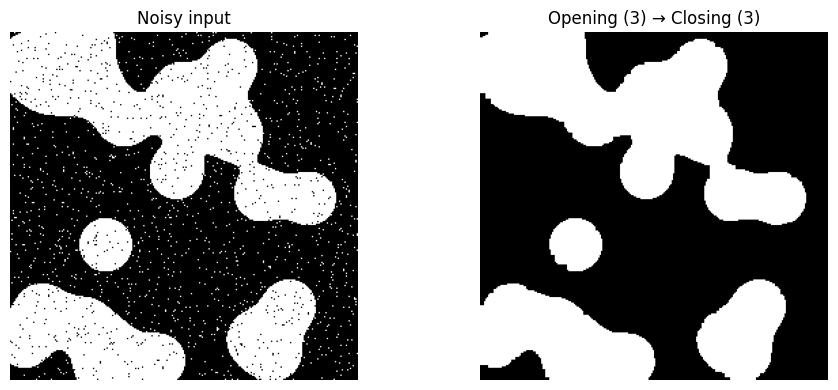

In [7]:
# First open to remove noise, then close to fill any remaining small gaps
opened_first = morph_opening(noisy, 3)
restored = morph_closing(opened_first, 3)

plot_comparison(noisy, restored,
                'Noisy input', 'Opening (3) → Closing (3)')

## 6. Discussion

### 6.1 Observations
- **Opening** completely eliminated isolated white pixels (salt noise) while preserving the main circular blobs. Larger kernels remove larger noise but also erode object boundaries.
- **Closing** successfully filled the cross‑shaped gaps and the interior hole when the kernel size was at least as large as the gap width. A 5×5 kernel was sufficient here; 7×7 smoothed the boundary slightly.
- Sequential **open‑close** produced a clean, gap‑free image from the noisy input, demonstrating practical noise‑and‑repair workflow.

### 6.2 Strengths
- Simple, fast, and interpretable.
- Works on binary images without requiring training data.
- Structuring element shape can be adapted (cross, ellipse) for directional sensitivity.

### 6.3 Limitations
- Not effective on non‑binary or heavily textured images without binarisation.
- Kernel size must be tuned manually; too large distorts object shape.
- Opening and closing are idempotent (repeating yields same result), but choosing the right order matters.

### 6.4 Real‑World Applications
| Domain          | Use Case                                      | Operation          |
|-----------------|-----------------------------------------------|--------------------|
| Document analysis | Remove scanned dust/speckles                | Opening            |
| Medical imaging | Separate touching cells, fill nuclei gaps    | Opening, Closing   |
| Industrial inspection | Detect defects by closing gaps          | Closing            |
| Biometrics      | Enhance fingerprint ridges                   | Closing            |

## 7. Conclusion

This project successfully demonstrated the use of morphological opening and closing for binary image enhancement. Through systematic experimentation with synthetic noisy and fragmented images, we verified:

- Opening removes small bright artefacts.
- Closing bridges narrow gaps and fills holes.
- The structuring element size directly controls the scale of features affected.

The provided Python implementation using OpenCV is efficient and can be easily adapted to real images after proper binarisation. Future work could explore adaptive kernel selection and application to grayscale morphology.

In [8]:
# Save selected results for the repository
cv2.imwrite('../images/processed/opening_result.png', morph_opening(noisy, 3))
cv2.imwrite('../images/processed/closing_result.png', morph_closing(gaps, 5))
print("Results saved to images/processed/")

Results saved to images/processed/
